# Unmap data from an image

Sometimes we'd like to rip **data** (i.e. the underlying digits) from a [pseudocolour (aka false colour) image](https://en.wikipedia.org/wiki/False_color). For example, maybe you found a nice map or seismic section in a paper, and want to try loading the data into some other software to play with.

The `gio.unmap()` function attempts to do this. Keep your hopes in check though: depending on the circumstances, it might be impossible. The following things will cause problems:

- **It's not a greyscale or perceptually linear colormap.** Getting data from greyscale images is easy, it's colours that cause problems. And I think soon I'll have a workflow that works especially well on perceptual colourmaps.
- **You don't know the colourmap and the colourbar is not included in or otherwise with the image.** I don't (yet) know of a way to reliably figure out the colourmap if you don't have it or know it.
- **You don't have a lot of pixels.** Small images are hard to rip data from. We'd always like more pixels.
- **There are a lot of annotations.** Usually these get in the way of the data.
- **The image is lossily compressed.** Most PDFs contain JPEGs and JPEG is [lossy](https://en.wikipedia.org/wiki/Lossy_compression). This means the colours are a bit garbled, especially around abrupt edges (like annotations!).
- **The image has hillshading.** The cute shadow effect adds another layer of complexity... but we can still have a go. 
- **It's a 3D perspective plot.** You might be able to recover the data from what you can _see_, but 3D perspective views add another type of distortion that I daresay could be undone, but not by me. 
- **The image is poor.** If it's a photo or scan of a paper document... well, now you 've got the unknown transform from the data to the image, then the unknown transform of the image to the physical plot, then the unknown transform of the plot to the image you have. I mean, come on.

We might be able to cope with two or three of these issues, but if they gang up on you, you might be out of luck. I'd love to hear how you get on!

As an aside, notice how the list above doubles as a set of requirements for making terrible scientific images!

## Get images from the web

Let's write a little function to load images from the Internet and transform them into NumPy arrays.

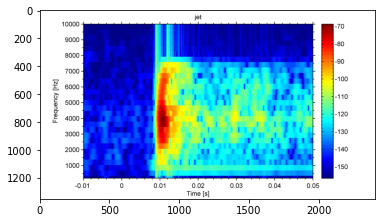

In [1]:
from io import BytesIO

import requests
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


def get_image_from_web(uri):
    data = requests.get(uri).content
    img = Image.open(BytesIO(data)).convert('RGB')
    rgb_im = np.asarray(img)[..., :3] / 255.
    return rgb_im

# An image from Matteo Niccoli's blog:
# https://mycartablog.com/2014/08/24/what-your-brain-does-with-colours-when-you-are-not-looking-part-1/
img = get_image_from_web('https://i0.wp.com/mycartablog.com/wp-content/uploads/2014/03/spectrogram_jet.png')

plt.imshow(img)

## An easy image

Let's start with that image, it looks approachable:

- It's large.
- It's a PNG, so losslessly compressed.
- No hillshading.
- It contains the colourmap, and Matteo tells us that it's `jet`

And, even better, when Matteo used it on his blog, he provided lots of other plots that we can compare to!

In [2]:
import gio

data = gio.unmap_to_dataarray(img, cmap='jet')

data.shape

(1351, 2402)

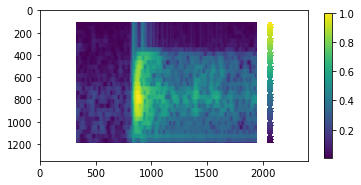

In [3]:
plt.imshow(data)
plt.colorbar(shrink=0.67)

Notice that the data ranges from 0 to 1, whereas in the image the colorbar is labelled from about -160 to -70. In the next section we'll fix that.

## Do more

We can do more!

We happen to know the colourmap was `jet` in this case, but we could give `gio` the pixel area of the colourmap, as a (left, top, right, bottom) tuple. We'll also pass in the **range** of the values, which we can estimate from the colourbar labels in the image. While we're at it, let's crop the result down to just the data area.

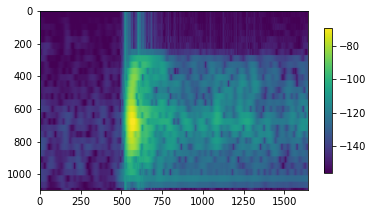

In [4]:
cmap = (2035, 102, 2079, 1198)       # (left, top, right, bottom)
crop = (312, 102, 1954, 1198)        # (left, top, right, bottom)
extent = (-0.01, 0.05, 200, 10_000)  # (left, right, bottom, top)
vrange = (-156.2, -69.0)
data = gio.unmap_to_dataarray(img, cmap=cmap, crop=crop, extent=extent, vrange=vrange)

plt.imshow(data)
plt.colorbar(shrink=0.67)

Nice! We can now go off and do things with this dataset.

## A more challenging image

Let's try an image with various issues:

- It's small.
- It's a JPEG.
- It has hillshading.

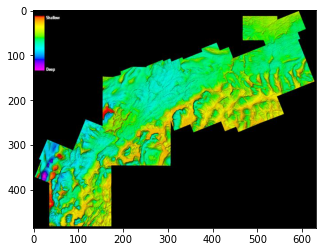

In [7]:
img = get_image_from_web("https://pbs.twimg.com/media/ELX9zxIWoAId3FT.jpg")
plt.imshow(img)

Awesome. This image is perfect. It's from a tweet by Chris Jackson: https://twitter.com/seis_matters/status/1204147545750065152

Let's try to rip data from it... Looking at [matplotlib's colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html)...

<img src="https://matplotlib.org/stable/_images/sphx_glr_colormaps_007.png" />

I think the closest is `'gist_rainbow'` so let's try that:

In [8]:
import gio

data = gio.unmap_to_dataarray(img, cmap='gist_rainbow', background='common', hillshade=True, threshold=0.4)

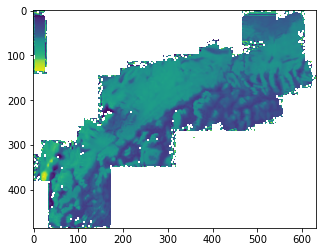

In [9]:
plt.imshow(data)

Not all that great, but it's a start. It looks like we'll need to tidy up the edges a bit -- they are all ragged because of JPEG compression artefacts.

Let's make a mask from the black pixels in the original image:

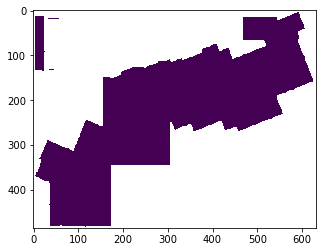

In [10]:
mask = np.ones_like(data)
mask[img.sum(axis=-1)<0.075] = np.nan

plt.imshow(mask)

And blank out the colourmap area:

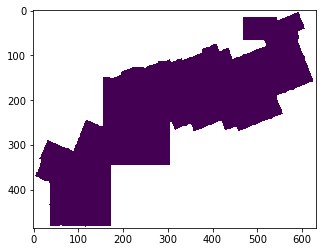

In [11]:
mask[:150, :75] = np.nan

plt.imshow(mask)

Now we can use this mask to pretty up our result:

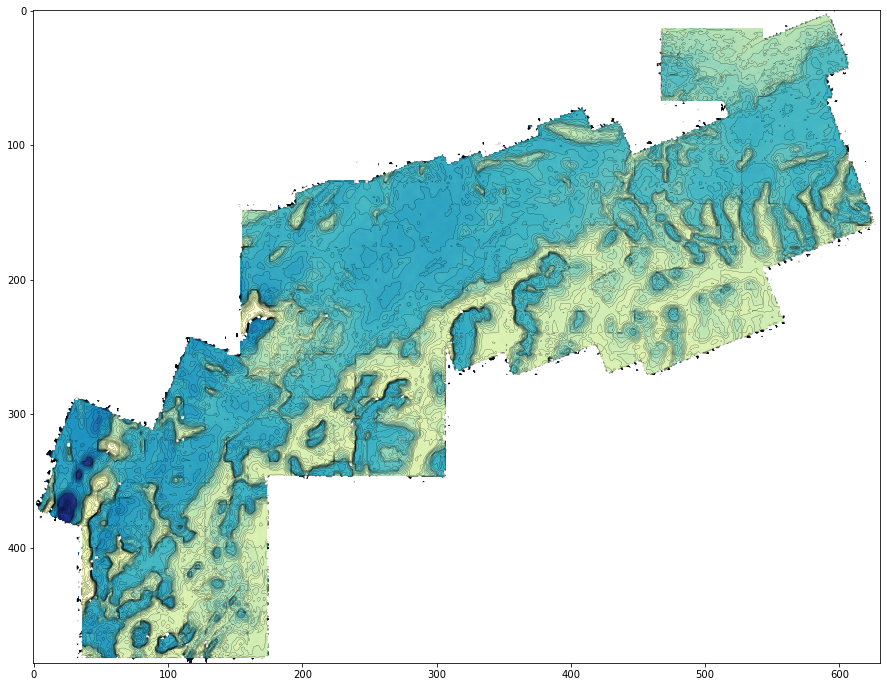

In [12]:
data *= mask

plt.figure(figsize=(18, 12))
plt.imshow(data, cmap='YlGnBu')
plt.contour(data, levels=np.arange(0, 1, 0.025), colors=['k'], linewidths=[0.2])

You can still see the JPEG compression artefacts in the data. We could apply some smoothing... but now we're getting into interpretation territory...

Good luck with your data liberation quest!